In [7]:
import jax.numpy as jnp
from jax import grad, jit, vmap, ops
import numpy as np
import jax
from jax.scipy.linalg import expm
import eigAD



From cosine lattice Hamiltonian:
$$
H(x)=-\frac{\hbar^{2}}{2 M} \frac{\mathrm{d}^{2}}{\mathrm{~d} x^{2}}+\frac{V_{0}}{2} \cos \left(2 k_{\mathrm{L}} x\right)
$$
We can use dimensionless coordinate $
z=k_{\mathrm{L}} x
$, and the energy scale for the problem $E_{\mathrm{R}}=\frac{\hbar^{2} k_{\mathrm{L}}^{2}}{2 M}$. We can rewrite the TISE as
$$
\left(\frac{\mathrm{d}^{2}}{\mathrm{~d} z^{2}}+\frac{E}{E_{\mathrm{R}}}-2 \frac{V_{0}}{4 E_{\mathrm{R}}} \cos (2 z)\right) \varphi(z)=0
$$
Using Bloch function $\varphi_{k}(x)=\mathrm{e}^{\mathrm{i} k x} u_{k}(x)$ to subsitute in:

$$
\left(-\frac{\mathrm{d}^{2}}{\mathrm{~d} z^{2}}+2 \frac{k}{k_{\mathrm{L}}} \frac{1}{\mathrm{i}} \frac{\mathrm{d}}{\mathrm{d} z}+\left(\frac{k}{k_{\mathrm{L}}}\right)^{2}+\frac{V_{0}}{2 E_{\mathrm{R}}} \cos (2 z)\right) u_{k}(z) 
= \frac{E(k)}{E_{\mathrm{R}}} u_{k}(z)
$$

Here, we modulate the optical lattice by a modulation function $f(t) \cos (2 z)$. The function here is a positive linear combination of sine waves. Thus, we make it into a time dependent problem.





In [2]:
# input parameter
freq = jnp.array([70])
lcm = 1/freq 
A = 3.5
alpha = 0.5

# tunning parameter
numStates=25
numSteps=31
numBands=5
fr=25.18
kpoints=500
Ttot =  lcm 
ftot = 1/Ttot
symmetry = True
if symmetry:
    kpoints = kpoints//2


In [3]:
freq_num = freq.shape[0]
dT = (1/max(freq))/numSteps

N = int(jnp.ceil(Ttot/dT))

tVec = jnp.linspace(0,Ttot,N)
dT = tVec[1] - tVec[0]
tVec = tVec[:-1]
tVec = tVec + dT/2


if symmetry:
    kvec=jnp.linspace(-1,0,kpoints)
else:
    kvec=jnp.linspace(-1,1,kpoints)

dTau = (2 * jnp.pi * fr) * dT


def tridiag(a, b, c, k1=-1, k2=0, k3=1):
    return jnp.diag(a, k1) + jnp.diag(b, k2) + jnp.diag(c, k3)



C = []
for i in range(2,numStates,2):
    C = C + [0,i]
C = jnp.array(C)
D = jnp.zeros(numStates)
M1 = tridiag(C,D,-1 * C)

E = [0]
for i in range(2,numStates,2):
    E = E + [(i)**2,(i)**2]
M2 = jnp.array(-np.diag(E))


F = jnp.concatenate((jnp.array([jnp.sqrt(2)]) , jnp.ones(numStates-3)))
M3 = jnp.diag(F,-2) + jnp.diag(F,2)




Here, we use the Hilbert spaces of
$$
\varphi_{\mu}(z)= \begin{cases}\sqrt{\frac{2}{\pi}} \sin ([\mu+1] z) & ; \mu=1,3,5, \ldots \\ \sqrt{\frac{2}{\pi}} \cos (\mu z) & ; \mu=2,4,6, \ldots .\end{cases}
$$
So that the matrix representations are
$$
-M2 = -\frac{\mathrm{d}^{2}}{\mathrm{~d} z^{2}}=\left(\begin{array}{cccccc}
0 & & & & & \\
& 4 & & & & \\
& & 4 & & & \\
& & & 16 & & \\
& & & & 16 & \\
& & & & & \ldots
\end{array}\right)
$$
$$
M1 = \frac{\mathrm{d}}{\mathrm{d} z}=\left(\begin{array}{llrlll}
0 & & & & & \\
& 0 & -2 & & & \\
& 2 & 0 & & & \\
& & & 0 & -4 & \\
& & & 4 & 0 & \\
& & & & & \ldots
\end{array}\right)
$$
$$
\frac{1}{2}M3 = \cos (2 z)=\frac{1}{2}\left(\begin{array}{ccccccc}
0 & 0 & \sqrt{2} & & & & \\
0 & 0 & 0 & 1 & & & \\
\sqrt{2} & 0 & 0 & 0 & 1 & & \\
& 1 & 0 & 0 & 0 & 1 \\
& & 1 & 0 & 0 & 0 \\
& & & 1 & 0 & 0 \\
& & & & \ldots &
\end{array}\right)
$$




In [4]:


@jax.jit
def perKstep(k):
    unitary = jnp.identity(M1.shape[0])
    for tt in range(tVec.shape[0]):
        t = tVec[tt]
        unitary = jnp.matmul(unitary,expm(-1j * dTau * createHmat(t,k)))
    return unitary

@jax.jit
def createHmat(t,k):
    modfunc = 1 + jnp.sum(alpha * jnp.sin(2 * jnp.pi * freq * t))
    newMat = (k**2) * jnp.identity(numStates) - 2* 1j * k * M1 -M2  - (1/4) * M3 * A * modfunc
    return newMat

def genUni():
    kMap = vmap(perKstep)
    return kMap(kvec)


By the time symmetry assertion of the Floquet picture, we require
$$
U(t+T, 0)=U(t, 0) U(T, 0)
$$
We write this one-cyle evolution operator as an exponential in the suggestive form
$$
U(T, 0)=\exp (-\mathrm{i} G T / \hbar)
$$
We can also define a unitary transformation
$$
P(t):=U(t, 0) \exp (+\mathrm{i} G t / \hbar)
$$
and it can be shown that the transformed wavefunction $|\psi(t)\rangle=P(t)|\tilde{\psi}(t)\rangle$ satisifies the "Schrodinger Equation",
$$
\mathrm{i} \hbar \frac{\mathrm{d}}{\mathrm{d} t}|\tilde{\psi}(t)\rangle= G|\tilde{\psi}(t)\rangle
$$
The Floquet band structure can be obtained from the eigenvalue of $G$. 
$$
\{\tilde{\epsilon}(n, k)\}=\operatorname{eig}(G(k))
$$
We can estimate $G$ using 
$$
U(T) \approx U\left(t_{1}\right) U\left(t_{2}\right) \ldots U\left(t_{N}\right)
$$ 
for each time step and take log of the eigenvalue of total $U(T)$.







In [5]:
res = genUni()
# check unitary
jnp.sum((res[0,:,:].conj().T - jnp.linalg.pinv(res[0,:,:]))**2)

DeviceArray(8.222287e-10-4.3320103e-10j, dtype=complex64)

In [8]:
def eigWrapper(mat):
    return eigAD.eig(mat)

eig = jax.jit(eigWrapper,backend='cpu')
b,vF =eig(res)
rawEfloquet = jnp.real(1j*jnp.log(b)* (ftot/fr) / (2*np.pi))

Nonsymmetric eigendecomposition is only implemented on the CPU backend. So we need to transfer it to CPU.
$$
G(k)=i \frac{1}{2 \pi} \frac{\omega_{R}}{\omega} \log (U(T))
$$
$$
\text{eig}(G(k))=i \frac{1}{2 \pi} \frac{\omega_{R}}{\omega}\log( \text{eig}(U(T)))
$$

To this end, we can select out the desired Floquet state $|\tilde{\epsilon}(n, k)\rangle$ by computing its probability overlap with the unperturbed spectrum $|\epsilon(n, k)\rangle$, and only examining those states with large overlap.
$$
P=|\langle\tilde{\epsilon}(n, k) \mid \epsilon(n, k)\rangle|^{2}
$$

In [9]:
@jax.jit
def blochStates(i):
    k = kvec[i]
    currF = vF[i,:,:] 
    H0 =  (k**2) * jnp.identity(numStates) - 2* 1j * k * M1 -M2  - (1/4) * M3 * A 
    a,vS = jnp.linalg.eigh(H0)
    vS = jnp.transpose(vS)
    Cvec = jnp.matmul(vS,jnp.conjugate(currF))
    Pvec = jnp.multiply(Cvec,jnp.conjugate(Cvec))
    inds = jnp.argmax(Pvec,axis=1)
    Efloquet = rawEfloquet[i,inds[:numBands]]
    return Efloquet


In [10]:
bandsF = vmap(blochStates)(jnp.arange(250))

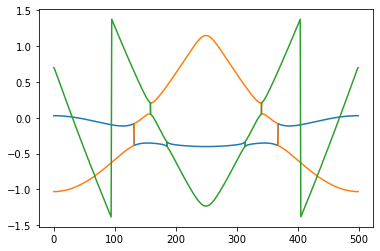

In [12]:
mirror = jnp.flip(bandsF,axis=0)
bandsF = jnp.concatenate((bandsF,mirror),axis=0)
import matplotlib.pyplot as plt
plt.plot(bandsF[:,:3])